# Forecasting with a stateful RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c07_forecasting_with_stateful_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [0]:
# set up is just creating the data

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

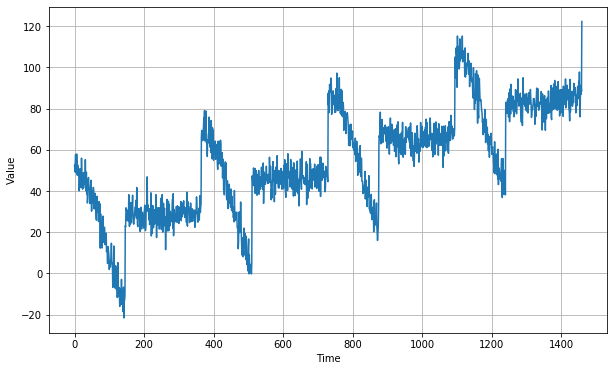

In [0]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [0]:
# To implement a stateful RNN, we need to:
# 1. Shift = window size
# 2. batch(1)
# 3. Dont shuffle

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [0]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [0]:
# create this class to reset the state at the beginning of each epoch:

class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [0]:
# first figure out learning rate

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,  # Use this function => Stateful = True
                         batch_input_shape=[1, None, 1]),  # Use this function => batch_input_shape = [1, None, 1]
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True), 
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(      # learning rate schedule to figure out the best learning rate
    lambda epoch: 1e-8 * 10**(epoch / 30))

reset_states = ResetStatesCallback()  # reset the state at the beginning of each epoch:

optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 2s 53ms/step - loss: 105.9340 - mae: 106.4340
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 70.8572 - mae: 71.3571
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 39.8080 - mae: 40.3047
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 27.3450 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 24.4956 - mae: 24.9892
Epoch 6/100
33/33 [==============================] - 0s 11ms/step - loss: 23.2601 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 22.0604 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 20.8543 - mae: 21.3463
Epoch 9/100
33/33 [==============================] - 0s 12ms/step - loss: 19.8307 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 0s 12ms/step - loss: 18.9399 - mae: 19.4319
Epoch 11/100
33/33 [=======

[1e-08, 0.0001, 0, 60]

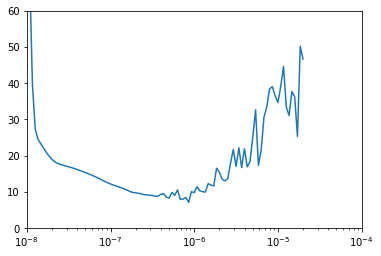

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, # Use this function => Stateful = True
                         batch_input_shape=[1, None, 1]),   # Use this function => batch_input_shape = [1, None, 1]
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True), # Use this function => Stateful = True
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9) # now using the right learning rate
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint( # checkpoints and early stopping
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50) # checkpoints and early stopping
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 52ms/step - loss: 60.2498 - mae: 60.7477 - val_loss: 25.0215 - val_mae: 25.5177
Epoch 2/500
33/33 [==============================] - 0s 14ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 18.7249 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 0s 14ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 0s 14ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 0s 14ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 0s 14ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [0]:
rnn_forecast.shape

(461,)

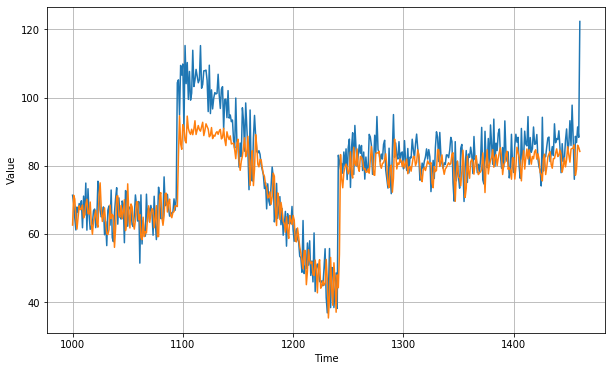

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.2778196